# Single Cell RNA-Seq

In this tutorial we are going to run through how UCDeconvolve can be used to aid in the analysis and annotation of
single-cell RNA-Sequencing data. For this tutorial, we are going to use the 'pbmc3k' dataset provided in the scanpy
datasets model at ``sc.datasets.pbmc3k()``. 

## Loading Packages & Authenticating
The first step in this analysis will be to load scanpy and ucdeconvolve after following the installation and registration instructions, and
authenticate our API. In this tutorial we saved our user access token in the variable ``TOKEN``.

In [2]:
import scanpy as sc
import ucdeconvolve as ucd

ucd.api.authenticate(TOKEN)

2023-04-25 13:07:57,966|[UCD]|INFO: Updated valid user access token.


%%eval-rst
|
.. note::
   By default the logging level is set to ``DEBUG``. To change logging levels you can import ``logging`` and set
   ``ucd.settings.verbosity`` directly. To reduce logs, change ``verbosity`` to ``logging.INFO``. In general we
   recommend keeping logging to ``DEBUG`` to provide status updates on a running deconvolution job.

## Loading & Preprocessing Data
We will now begin by loading our pbmc dataset.

In [3]:
adata = sc.datasets.pbmc3k()

We will save raw counts data into adata, which can serve as an input to ucd functions. Unicell will detect non-logarithmized
counts data and automatically normalize our data. We will run a quick built-in preprocssing functions using scanpy to
obtain some clustered data. This step will take a minute or two to complete.

In [ ]:
adata.raw = adata

sc.pp.recipe_seurat(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors = 30)
sc.tl.umap(adata, min_dist = 0.1)
sc.tl.leiden(adata, resolution = 0.75)

We plot the UMAP of our dataset using leiden clusters as an overlay and see the following image:

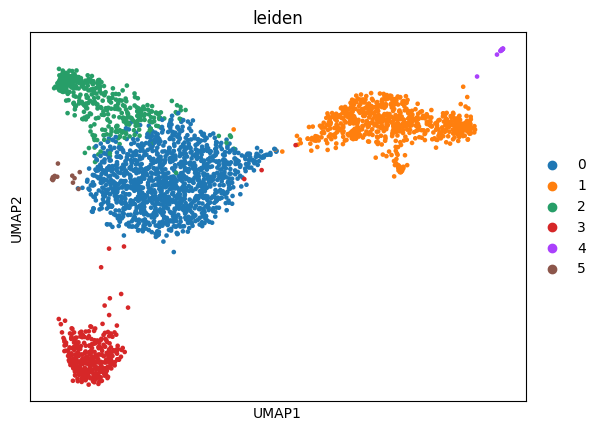

In [29]:
sc.pl.umap(adata, color = 'leiden')

## Initial Cluster Identification Using UCDBase 
To get a general sense of the celltypes most likely present in this dataset, we want to first run ``ucd.tl.base`` which
will return context-free deconvolutions of cell type states.

In [7]:
ucd.tl.base(adata)

2023-04-25 13:10:28,425|[UCD]|INFO: Starting UCDeconvolveBASE Run. | Timer Started.
Preprocessing Dataset | 100% (11 of 11) || Elapsed Time: 0:00:01 Time:  0:00:01
2023-04-25 13:10:30,501|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 13:10:31,339|[UCD]|INFO: Upload Complete | Elapsed Time: 0.838 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | / |#| 0 Elapsed Time: 0:00:00
Waiting For Submission : UNKNOWN | Queue Size : 0 | - |#| 1 Elapsed Time: 0:00:01
Waiting For Submission : UNKNOWN | Queue Size : 0 | \ |#| 2 Elapsed Time: 0:00:03
Waiting For Submission : QUEUED | Queue Size : 1 | | |#| 3 Elapsed Time: 0:00:04
Waiting For Submission : RUNNING | Queue Size : 1 | / |#| 3 Elapsed Time: 0:00:04
Waiting For Submission : RUNNING | Queue Size : 1 | | |#| 3 Elapsed Time: 0:00:04
Waiting For Completion | 100% (2700 of 2700) || Elapsed Time: 0:00:28 Time:  0:00:28
2023-04-25 13:11:07,163|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 13:11:08,505|[UCD]|INFO: Download

### Plotting Clustermap
To get a general sense of the deconvolution results, let's plot a clustermap that aggregates base predictions on the basis
of leiden cluster using the function ``ucd.pl.base_clustermap``

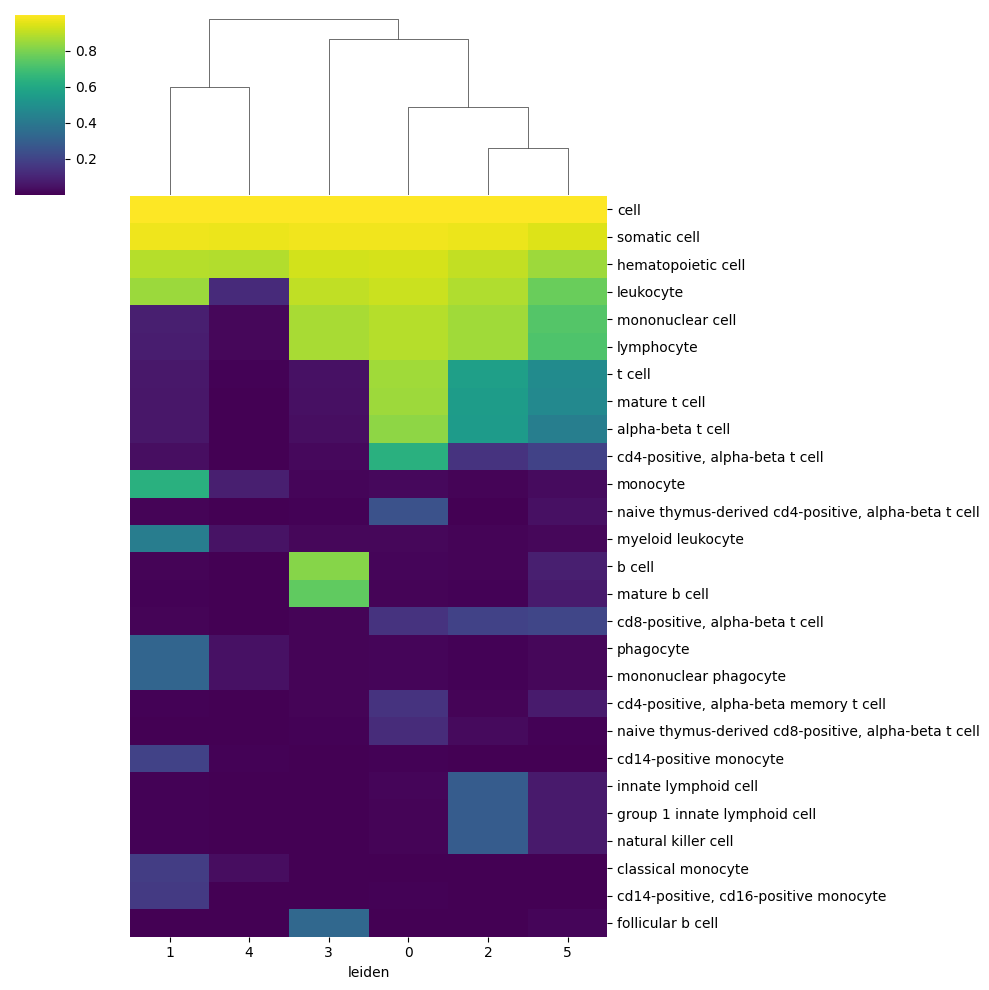

In [30]:
ucd.pl.base_clustermap(adata, groupby = 'leiden')

We can see that the predictions shown in the clustermap are hierarchecal. By default, ucdeconvolve base performs belief propagation, which takes flattened predictions and aggregates them up a cell type heirarchy. This flag can be set in the ``ucd.tl.base`` function as ``propagate = False``. For most cases we reccomend peforming belief propagation, as it accounts for uncertainty in ground-truth labels used during training. 

In either case, we can use this clustering information to label our dataset by selecting the most likely detailed cell subtype, using ucdbase to guide us to an answer faster than performing manual curation.

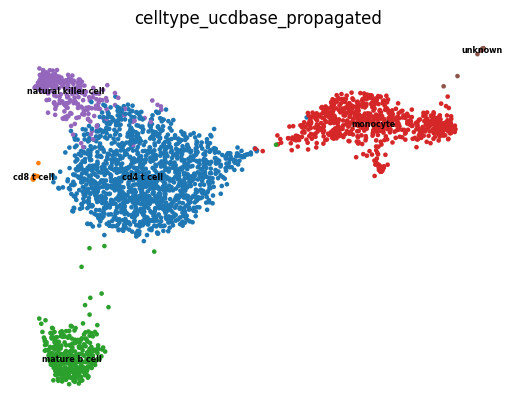

In [13]:
label = "celltype_ucdbase_propagated"
adata.obs[label] = 'unknown'
adata.obs.loc[adata.obs.leiden.isin(("2", "5")), label] = "monocyte"
adata.obs.loc[adata.obs.leiden.isin(("3",)), label] = "mature b cell"
adata.obs.loc[adata.obs.leiden.isin(("0","1")), label] = "cd4 t cell"
adata.obs.loc[adata.obs.leiden.isin(("4",)), label] = "natural killer cell"
adata.obs.loc[adata.obs.leiden.isin(("7",)), label] = "cd8 t cell"

sc.pl.umap(adata, color = 'celltype_ucdbase_propagated', legend_loc = 'on data',
           legend_fontsize = "xx-small", frameon = False)

## Examining Feature Attributions with UCDExplain
To gain some additional insight into the cell types being predicted for each cluster, we can leveraged **integrated gradients**
which is implemented in the ``ucd.tl.explain`` module. This method takes a target output for the ucdbase model and computes
attribution scores for all input genes. A positive attribution score indicates that a given gene's expression is positively
associated with the prediction of that given cell type (i.e. canonical marker genes tend to have high feature attribution scores
for their corresponding cell types) while a negative attribution score indicates that a given gene's expression is negatively
associated with the prediction of that given cell type (i.e. it may be a canonical marker of another cell type). We can use
feature attributions to validate some of our predictions by confirming that the top genes associated with a given cell type
are concordant with biological phenomena. 

### Examining Raw Predictions
To do this, we first must examine the models raw, non-propagated predictiosn. As feature attributions using integrated gradients
relies on the core wieghts underpinning the ucdbase deep learning model, it does not consider belief propagation which is a post-processing
function. Therefore, we ned to first get a sense of the "raw" cell type predictions made for each cluster.

We can plot raw cell type predictions using the same clustermap function above, but this time adding an additional parameter.


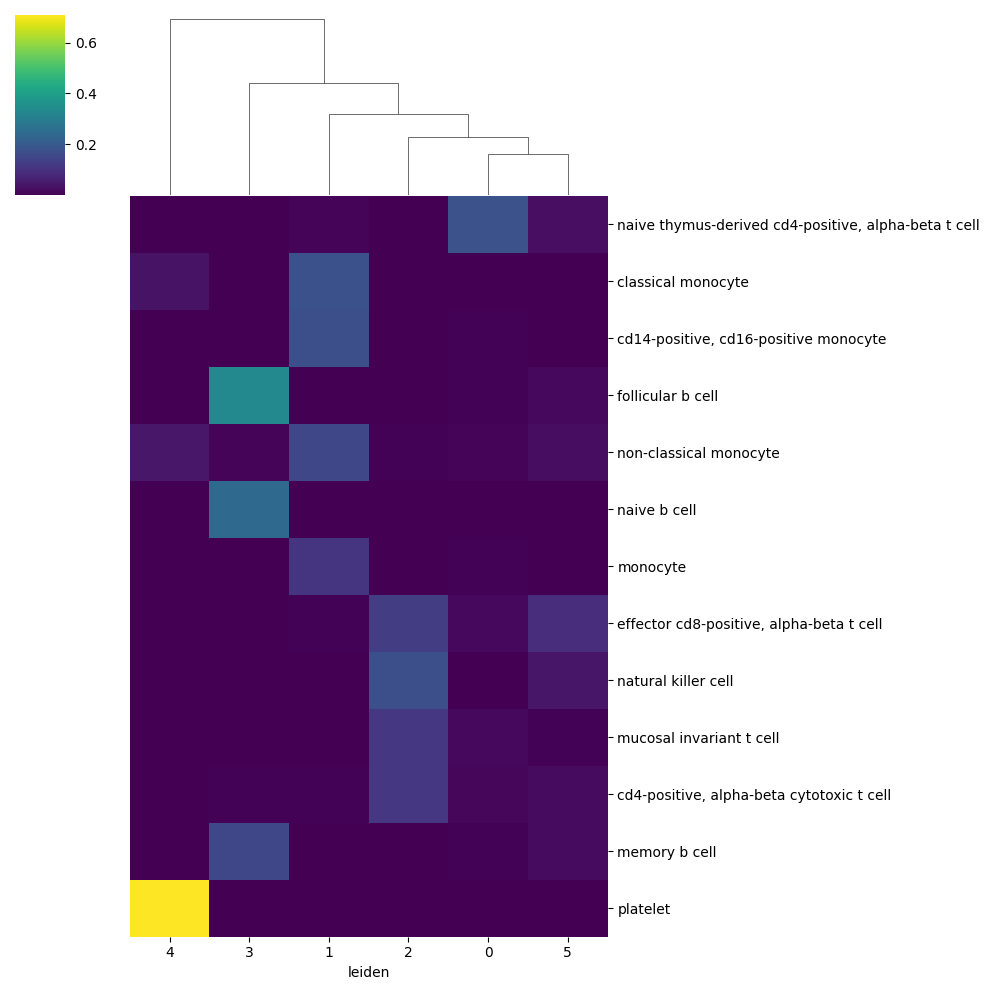

In [39]:
ucd.pl.base_clustermap(adata, groupby = 'leiden', category = 'raw', n_top_celltypes=50)

We can immediately see that these predictions are alot more specific for each cluster. We include a utility function to assign
target cell types from predictions to each cluster, and can use this 'raw' prediction information to collect feature attributions
for each cluster individually. This functions creates a new column in ``adata.obs`` entitled ``pred_celltype_{key}`` which in our case
key, which represents the name of the run call, defaults to ``ucdbase``, therefore our column is called ``pred_celltype_ucdbase``.

In [32]:
ucd.utils.assign_top_celltypes(adata, category = "raw", groupby = "leiden")

Let's plot the resulting 'raw' assigned celltypes over our UMAP and compre them
with our aggregated propagation assignments we performed semi-manually.

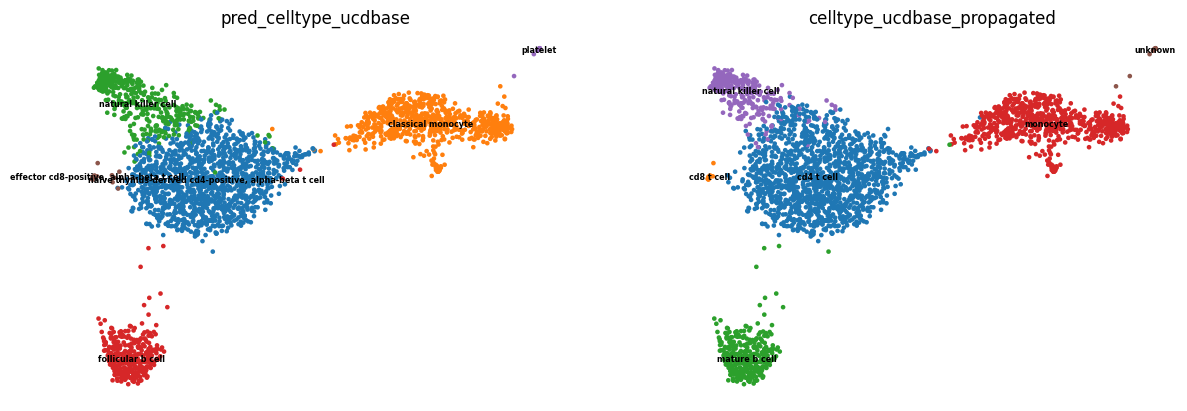

In [33]:
sc.pl.umap(adata, color = ["pred_celltype_ucdbase", "celltype_ucdbase_propagated"],
           legend_loc = 'on data', legend_fontsize = 'xx-small', frameon = False)

### Running UCDExplain

%%eval-rst
.. warning::
   As feature attributions is a highly computationally intensive operation, for scRNA-Seq data where each cell
   is considered a sample, we **highly recommend utilizing the subsampling capabilities** built into ``ucd.tl.explain``
   to speed up peformance. When run at the cluster-level, we find that subsampling a sufficient number of cells from
   each cluster provides the same level of feature attribution granularity as one would gain running all cells.

Let's start by retrieving a dictionary mapping our groups in ``leiden`` to our
raw celltypes. The ``assign_top_celltypes`` function has a parameter that can be
set ``inplace = False`` which will return the dictionary directly.

In [49]:
# We can retrieve 
celltypes = ucd.utils.assign_top_celltypes(adata, category = "raw", groupby = "leiden", inplace = False)

In [51]:
adata.obs

,n_genes,leiden,celltype_ucdbase_propagated,pred_celltype_ucdbase
index,,,,
AAACATACAACCAC-1,781,0,cd4 t cell,"naive thymus-derived cd4-positive, alpha-beta ..."
AAACATTGAGCTAC-1,1352,3,mature b cell,follicular b cell
AAACATTGATCAGC-1,1131,0,cd4 t cell,"naive thymus-derived cd4-positive, alpha-beta ..."
AAACCGTGCTTCCG-1,960,1,monocyte,classical monocyte
AAACCGTGTATGCG-1,522,2,natural killer cell,natural killer cell
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1,monocyte,classical monocyte
TTTCTACTGAGGCA-1,1227,3,mature b cell,follicular b cell
TTTCTACTTCCTCG-1,622,3,mature b cell,follicular b cell


In [50]:
ucd.tl.explain(adata, celltypes = celltypes, groupby = "leiden")

2023-04-25 13:52:53,547|[UCD]|INFO: Starting UCDeconvolveEXPLAIN Run. | Timer Started.
2023-04-25 13:52:53,562|[UCD]|INFO: Run Complete | Elapsed Time: 0.014 (s)


KeyError: 'leiden'

In [23]:
adata.obs['pred_celltype_ucdbase'].value_counts()

pred_celltype_ucdbase
naive thymus-derived cd4-positive, alpha-beta t cell    1415
classical monocyte                                       497
follicular b cell                                        338
natural killer cell                                      257
non-classical monocyte                                   170
platelet                                                  15
plasmablast                                                8
Name: count, dtype: int64